In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=5, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generates position embedding
# 3.2 create mask. (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention
# 4. builds model
# 4.1 MultiheadAttention
# 4.2 EncoderLayer
# 4.3 DecoderLayer
# 4.4 EncoderModel
# 4.5 DecoderModel
# 4.6 Transformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

In [3]:
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info = True,
                           as_supervised = True)

train_examples, val_examples = examples['train'], examples['validation']
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    urls=['https://github.com/neulab/word-embeddings-for-nmt'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string, encoder=None),
        'pt': Text(shape=(), dtype=tf.string, encoder=None)
    },
    total_num_examples=54781,
    splits={
        'test': <tfds.core.SplitInfo num_examples=1803>,
        'train': <tfds.core.SplitInfo num_examples=51785>,
        'validation': <tfds.core.SplitInfo num_examples=1193>
    },
    supervised_keys=('pt', 'en'),
    citation='"""
        @inproceedings{Ye2018WordEmbeddings,
          author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
          title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
   

In [4]:
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'o problema \xc3\xa9 que nunca vivi l\xc3\xa1 um \xc3\xbanico dia .'
b"except , i 've never lived one day of my life there ."

b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'
b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them ."

b'agora aqui temos imagens sendo extra\xc3\xaddas em tempo real diretamente do feed ,'
b'now here are live images being pulled straight from the feed .'

b'agora : um , dois , tr\xc3\xaas , vai .'
b'so : one , two , three , go .'

b'eventualmente , vamos ver se teremos todos os sentidos humanos empregues , e se vamos ter meios para viver a hist\xc3\xb3ria qualquer que seja a via escolhida .'
b'eventually , we can see i

In [5]:
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)


In [6]:
sample_string = "Transformer is awesome."

tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"
1248 --> "ran"
7946 --> "s"
7194 --> "former "
13 --> "is "
2799 --> "awesome"
7877 --> "."


In [7]:
buffer_size = 20000
batch_size = 64
max_length = 40

def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)

def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
    

In [8]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

W0804 07:09:00.523236 140247652361984 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0804 07:09:00.525246 140247652361984 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0804 07:09:00.527645 140247761401600 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0804 07:09:00.528782 140247761401600 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0804 07:09:00.531126 140247744616192 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string


(64, 40) (64, 40)
(64, 38) (64, 40)
(64, 40) (64, 40)
(64, 39) (64, 39)
(64, 37) (64, 38)


In [9]:
# PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

# pos.shape: [sentence_length, 1]
# i.shape  : [1, d_model]
# result.shape: [sentence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000,
                               (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # sines.shape: [sentence_length, d_model / 2]
    # cosines.shape: [sentence_length, d_model / 2]
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


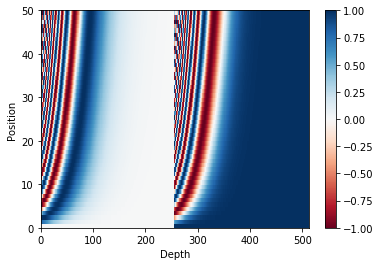

In [10]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap = 'RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plot_position_embedding(position_embedding)

In [11]:
# 1. padding mask, 2. look ahead

# batch_data.shape: [batch_size, seq_len]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=313180, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [12]:
# attention_weights.shape: [3,3]
# [[1, 0, 0],
#  [4, 5, 0],
#  [7, 8, 9]]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

create_look_ahead_mask(3)

<tf.Tensor: id=313189, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        # 使得在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis = -1)
    
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)
    

In [14]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32) # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)
np.set_printoptions(suppress=True)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [15]:
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [16]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [17]:
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype=tf.float32) # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [18]:
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上:
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    
    实战中:
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    
    实战中技巧：
    q -> Wq -> Q -> split -> q0, q1, q2...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        
        x = tf.reshape(x,
                       (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.WQ(q) # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape: (batch_size, seq_len_k, d_model)
        v = self.WV(v) # v.shape: (batch_size, seq_len_v, d_model)
        
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
        
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0, 2, 1, 3])
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs,
                                      (batch_size, -1, self.d_model))
        
        # output.shape : (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 256)) # (batch_size, seq_len_q, dim)
output, attn = temp_mha(y, y, y, mask = None)
print(output.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


In [19]:
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [20]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape          : (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        # out1.shape       : (batch_size, seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


In [21]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 由look_ahead_mask和decoder_padding_mask合并而来
        
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        # attn1, out1.shape : (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape : (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(attn2 + out1)
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2
    
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)
print(sample_decoder_attn_weights2.shape)
        

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


In [22]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training,
                                       encoder_padding_mask)
        
        # x.shape: (batch_size, input_seq_len, d_model)
        return x
    
sample_encoder_model = EncoderModel(2, 8500, max_length,
                                    512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [23]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")
        
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                'decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights[
                'decoder_layer{}_att2'.format(i+1)] = attn2
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights

sample_decoder_model = DecoderModel(2, 8000, max_length,
                                    512, 8, 2048)

sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att \
= sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,
    training = False, decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)

(64, 35, 512)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)


In [24]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training,
            decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights
    
sample_transformer = Transformer(2, 8500, 8000, max_length,
                                 512, 8, 2048, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(
    temp_input, temp_target, training = False,
    encoder_padding_mask = None,
    decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(predictions.shape)
for key in attention_weights:
    print(key, attention_weights[key].shape)
        

(64, 31, 8000)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)
decoder_layer1_att1 (64, 8, 31, 31)


In [25]:
# 1. initializes model.
# 2. define loss, optimizer, learning_rate schedule
# 3. train_step
# 4. train process

In [26]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

In [27]:
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5),
#                                 step_num * warm_up_steps **(-1.5))

class CustomizedSchedule(
    keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1 = 0.9,
                                  beta_2 = 0.98,
                                  epsilon = 1e-9)

Text(0.5, 0, 'Train step')

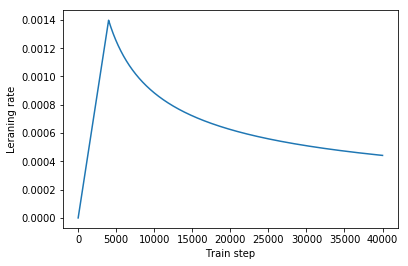

In [28]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)

plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

In [29]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


In [30]:
def create_masks(inp, tar):
    """
    Encoder:
      - encoder_padding_mask (self attention of EncoderLayer)
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      - decoder_padding_mask (self attention of DecoderLayer)
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask,
                              look_ahead_mask)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [31]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

In [32]:
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)

(64, 38)
(64, 38)


(<tf.Tensor: id=456583, shape=(64, 1, 1, 38), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: id=456615, shape=(64, 1, 38, 38), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1

In [33]:
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')

@tf.function
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

epochs = 20
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(
        time.time() - start))
    

Epoch 1 Batch 0 Loss 4.1286 Accuracy 0.0013
Epoch 1 Batch 100 Loss 4.1847 Accuracy 0.0133
Epoch 1 Batch 200 Loss 4.0660 Accuracy 0.0200
Epoch 1 Batch 300 Loss 3.9233 Accuracy 0.0236
Epoch 1 Batch 400 Loss 3.7440 Accuracy 0.0310
Epoch 1 Batch 500 Loss 3.5987 Accuracy 0.0376
Epoch 1 Batch 600 Loss 3.4758 Accuracy 0.0443
Epoch 1 Batch 700 Loss 3.3677 Accuracy 0.0512
Epoch 1 Loss 3.3654 Accuracy 0.0513
Time take for 1 epoch: 1228.2845702171326 secs

Epoch 2 Batch 0 Loss 2.5084 Accuracy 0.0984
Epoch 2 Batch 100 Loss 2.5704 Accuracy 0.1066
Epoch 2 Batch 200 Loss 2.5166 Accuracy 0.1106
Epoch 2 Batch 300 Loss 2.4856 Accuracy 0.1144
Epoch 2 Batch 400 Loss 2.4452 Accuracy 0.1175
Epoch 2 Batch 500 Loss 2.4168 Accuracy 0.1205
Epoch 2 Batch 600 Loss 2.3900 Accuracy 0.1230
Epoch 2 Batch 700 Loss 2.3664 Accuracy 0.1254
Epoch 2 Loss 2.3657 Accuracy 0.1255
Time take for 1 epoch: 83.50327587127686 secs

Epoch 3 Batch 0 Loss 2.0950 Accuracy 0.1334
Epoch 3 Batch 100 Loss 2.1885 Accuracy 0.1424
Epoch 3 Bat

Epoch 19 Batch 100 Loss 0.6003 Accuracy 0.3367
Epoch 19 Batch 200 Loss 0.5938 Accuracy 0.3368
Epoch 19 Batch 300 Loss 0.5967 Accuracy 0.3376
Epoch 19 Batch 400 Loss 0.5941 Accuracy 0.3374
Epoch 19 Batch 500 Loss 0.5945 Accuracy 0.3375
Epoch 19 Batch 600 Loss 0.5944 Accuracy 0.3374
Epoch 19 Batch 700 Loss 0.5927 Accuracy 0.3379
Epoch 19 Loss 0.5925 Accuracy 0.3379
Time take for 1 epoch: 81.16860604286194 secs

Epoch 20 Batch 0 Loss 0.5969 Accuracy 0.3201
Epoch 20 Batch 100 Loss 0.5806 Accuracy 0.3391
Epoch 20 Batch 200 Loss 0.5727 Accuracy 0.3396
Epoch 20 Batch 300 Loss 0.5745 Accuracy 0.3411
Epoch 20 Batch 400 Loss 0.5710 Accuracy 0.3409
Epoch 20 Batch 500 Loss 0.5711 Accuracy 0.3411
Epoch 20 Batch 600 Loss 0.5708 Accuracy 0.3411
Epoch 20 Batch 700 Loss 0.5698 Accuracy 0.3415
Epoch 20 Loss 0.5696 Accuracy 0.3415
Time take for 1 epoch: 80.9169328212738 secs



In [62]:
"""
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
"""
def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape: (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1),
                               tf.int32)
        
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        

In [70]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize = (16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        
        ax.matshow(attention[head][:-1, :])
        
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()      

In [71]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name)

In [65]:
translate('está muito frio aqui.')

Input: está muito frio aqui.
Predicted translation: it 's very cold here .


In [66]:
translate('isto é minha vida')

Input: isto é minha vida
Predicted translation: this is my life-altering .


In [67]:
translate('você ainda está em casa?')

Input: você ainda está em casa?
Predicted translation: are you still home ?


In [68]:
translate('este é o primeiro livro que eu já li')

Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book that i already have .


Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book that i already have .


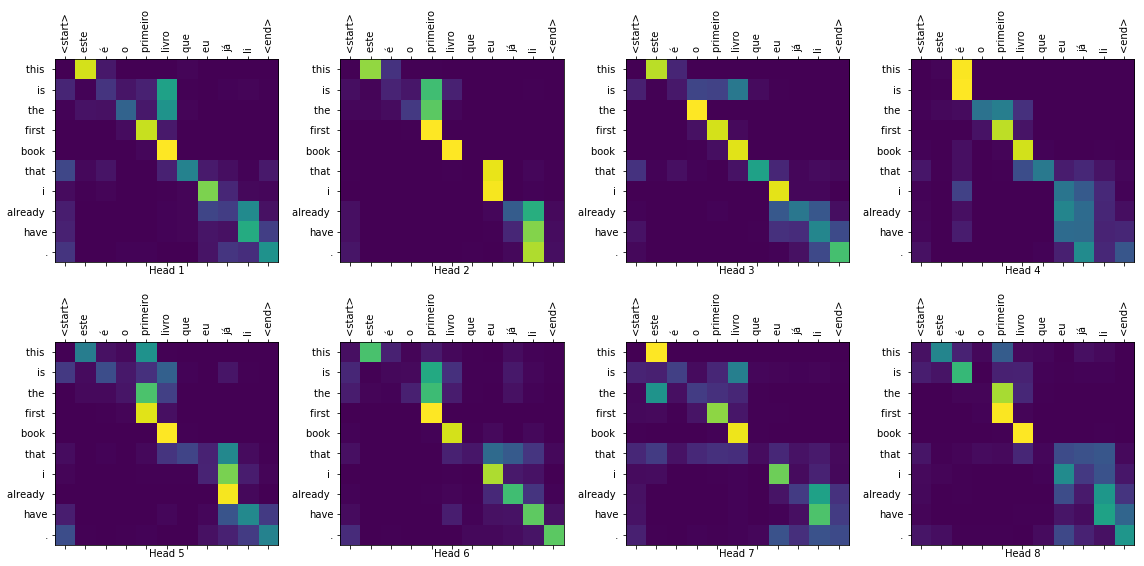

In [72]:
translate('este é o primeiro livro que eu já li',
          layer_name = 'decoder_layer4_att2')